# Transfer learning and Fine Tuning
+ 이번 과정도  콘크리트 이미지 데이터를 가지고 DataSet을 만들어 이미지 분류 모델을 만들도록 하겠습니다.
+ 저번 실습과 다른점은 Transfer Learning을 활용하여 모델링하고 Fining Tunning도 하도록 하겠습니다.
+ 손쉽게 이미지 DataSet을 만들기 위해 ImageDataGenerator 와 flow_from_directory 활용합니다.

### 학습목차
##### A. ImageDataGenerator 와 flow_from_directory 이용하여 데이터셋 만들기
1. 필요한 라이브러리 임포트
2. 이미지 파일 가져오기 : concrete_image.zip
3. 이미지 파일 하나 읽어 이미지 보기
4. Data Preprocess : ImageDataGenerator 와 flow_from_directory 이용하여 이미지 데이터셋 생성, 라벨링 한꺼번에 처리

##### B. MobileNet Transfer Learning & Fine-tuning 모델링
1. Build Model : Functional API
2. Callback
3. 모델 학습
4. 성능 그래프
5. Predict : 100% 성능 보여줌

## A. ImageDataGenerator 와 flow_from_directory 이용하여 데이터셋 만들기

### 1. 필요한 라이브러리 임포트

In [ ]:
from glob import glob
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

### 2. 이미지 파일 가져오기 : concrete_image.zip

In [ ]:
# 업로드한 concrete_image.zip 파일 확인
glob('concrete_image.zip')

['concrete_image.zip']

In [ ]:
# 이미지 폴더 있는지 확인
if not os.path.exists('IMAGE'):
    os.mkdir('IMAGE')

    # concrete_image.zip 압축풀기 : 4분 소요
    import zipfile
    with zipfile.ZipFile('concrete_image.zip', 'r') as zip_ref:
        zip_ref.extractall('IMAGE')

In [ ]:
# concrete_image Negative 폴더 안의 이지미 갯수
!ls -l ./IMAGE/Negative/ | grep jpg | wc -l

3000


In [ ]:
# concrete_image Positive 폴더 안의 이지미 갯수
!ls -l ./IMAGE/Positive/ | grep jpg | wc -l

3000


### 3.. 이미지 파일 하나 읽어 이미지 보기

In [ ]:
# 이미지 패스 지정
path = './IMAGE/Negative/00001.jpg'

In [ ]:
# 이미지 읽어오기
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)

In [ ]:
# 이미지 shape 확인
image.shape

TensorShape([227, 227, 3])

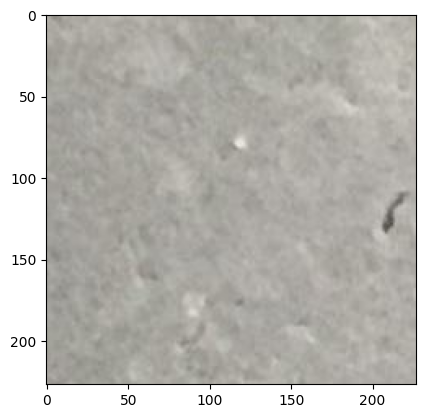

In [ ]:
# 읽어온 Negative 이미지 보기
plt.imshow(image)
plt.show()

### 4. Data Preprocess

### ImageDataGenerator 와 flow_from_directory 이용하여 이미지 데이터셋 생성, 라벨링(라벨인코딩,원핫인코딩) 한꺼번에 처리 할수 있다.
### <font color=red>[조건] IMAGE 폴더 있고 그 아래 각 class별 이름 폴더가 있고 class별 폴더 안에 이미지 파일 있을 경우, 아래 수행합니다.</font>

- class 폴더 이름을 label로 취급
- 이미지 읽어 메모리 올리기
- flow_from_directory 함수에서 이미지 사이즈 변경 : 227,227 --> 224,224 > MobileNetV2은 [96, 128, 160, 192, 224] 사이즈만 지원
- class 폴더 이름 label을 One-Hot-Encoding 수행
- 이미지, 라벨 튜플 묶고, shuffle, batch 후 데이터셋 생성


In [ ]:
# Hyperparameter Tunning

num_epochs = 10
batch_size =32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (224, 224, 3)  # 사이즈 확인
num_classes = 2    # Postive , Negative

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### ImageDataGenerator 와  flow_from_directory 기능
+ ImageDataGenerator : 이미지 데이터에 대해 증강(augmentation)과 rescaling, validation_split 등의 전처리 기능 수행
+ flow_from_directory : 실제 이미지 데이터 읽고 배치, 셔플하고 labeling 수행 및 데이터셋 생성

In [ ]:
# ImageDataGenerator 이용하여 이미지 증강과 전처리하기
# - 여기서는 data augmentation 하지 않음 : 주석처리했으며 필요하면 주석해체하여 사용하면 됨
# - 1개 IMAGE 폴더로 Train, Test dataset으로 나누어야 되므로 validation_split 사용해야 함
# - validation 데이터 사이즈 입력 : validation_split=0.2 --> train set : valid set = 8 : 2
# - (주의점) MobileNetV2에 인풋으로 사용하기 전에 전 처리하는 코드가 preprocess_input으로 함수화 되어 있습니다. 따라서 그대로 사용하시면 됩니다.
# - 그래서 rescale 수행하지 않음

image_datagen = ImageDataGenerator(
      #rescale=1. / 255,        # MobileNetV2 경우, 아래 preprocess_input 호출해서 리스케일 하므로 커멘트 처리함
      validation_split=0.2,     # train set : valid set = 8 : 2
      preprocessing_function = preprocess_input  # MobileNetV2 사용한다면 전처리 코드를 넣어 주면 됩니다.
#       rotation_range=30,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       shear_range=0.1,
#       zoom_range=0.1,
#       horizontal_flip=True,
#       fill_mode='nearest'
    )

In [ ]:
# ImageDataGenerator.flow_from_directory
# - 이미지 폴더 내의 데이터  읽고 배치 , 셔플하고 labeling 수행
# - 2개 Class에 대한 라벨링(라벨인코딩,원핫인코딩) 수행
# - MobileNetV2은 [96, 128, 160, 192, 224] 사이즈만 지원하므로 flow_from_directory 함수에서 사이즈 변경함
# - subset = 'training' --> training_generator 생성
# - subset = 'validation' --> test_generator 생성
# - 수행결과, IMAGE 폴더로 Train 4,800건, Test 1,200건 dataset 만듬

# IMAGE 포더 밑에 .ipynb_checkpoints 폴더 있을경우 폴데 삭제
!rm -rf ./IMAGE/.ipynb_checkpoints

training_generator = image_datagen.flow_from_directory(
    './IMAGE',
    batch_size=batch_size,
    target_size=(224, 224),       # 원하는 출력 사이즈 입력. MobileNetV2 위해 사이즈 변경 : 227,227 --> 224,224. 최종 출력 : (224,224,3)
    class_mode = 'categorical',   # binary , categorical
    shuffle = True,
    subset = 'training'           # training, validation. ImageDataGenerator의 validation_split 사용하므로 subset 지정
    )

test_generator = image_datagen.flow_from_directory(
    './IMAGE',
    batch_size=batch_size,
    target_size=(224, 224),       # 원하는 출력 사이즈 입력. MobileNetV2 위해 사이즈 변경 : 227,227 --> 224,224. 최종 출력 : (224,224,3)
    class_mode = 'categorical',   # binary , categorical
    shuffle = False,
    subset = 'validation'         # training, validation. ImageDataGenerator의 validation_split 사용하므로 subset 지정
    )

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [ ]:
# Train, test 건수 확인
len(training_generator) * 32 , len(test_generator) * 32

(4800, 1216)

In [ ]:
# class 이름 및 번호 매핑 확인
print(training_generator.class_indices)

{'Negative': 0, 'Positive': 1}


True Value :  [0. 1.]


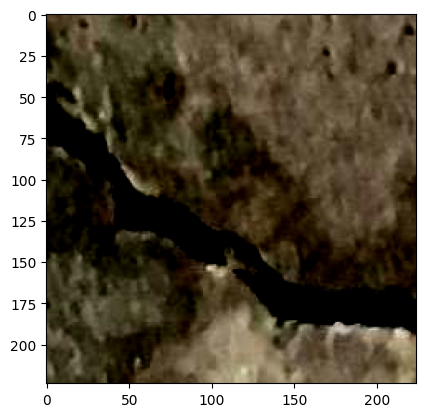

In [ ]:
batch_img, batch_label = next(iter(training_generator))

print('True Value : ', batch_label[0])  # 32개의 사진 이미지중 첫번째 사진의 라벨
plt.imshow(batch_img[0])   # 32개의 사진 이미지중 첫번째 사진 이미지
plt.show()

## B. MobileNet Transfer Learning & Fine-tuning 모델링

### 1. Build Model

In [ ]:
# 케라스 applicatioins에 어떤 종류의 모델 있는지 확인
dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'Re

In [ ]:
# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 Transfer Learning 사용하며 됩니다. 우리는 그냥 불러다 사용할줄 알면 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# MobileNet V2 베이스 모델의 파라미터를 학습하지 않도록 고정하기
base_model.trainable = False

In [ ]:
# Transfer Learning 과 Fine Tuning 으로 모델 구축
# - GlobalAveragePooling2D 레이어 : 2D 입력 텐서의 공간 차원을 평균화하여 하나의 벡터로 변환합니다. 즉, 7 X 7 를 Average pooling해서 1개 벡터 변환
# - 이 레이어는 입력의 공간 위치를 무시하고, 전체적인 패턴을 파악 도움이 되며, 모델의 파라미터 수를 크게 줄일수 있음

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 --> Dense 입력 할수 있게 된다.
output = tf.keras.layers.Dense(2, activation='softmax')(x)  # Fine Tuning

model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

### 2. Callback

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# ReduceLROnPlateau : val_loss가 2번 이상 감소되지 않으면 lr * factor = lr 새로운 lr로 변경해서 학습 진행
lrReducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

### 3. 모델 학습

In [ ]:
# ImageDataGenerator 와 flow_from_directory 이용하여 DataSet을 만들었으며
# num_epochs = 10
# batch_size = 32
# 앞쪽의 CNN 모델과 Transfer Learning 모델과 비교하면 엄청난 성능차이를 알수 있음.(첫 epoch에 val_accuracy 98% 성능 보임)

history = model.fit(
    training_generator,
    validation_data = test_generator,
    epochs=5,
    batch_size = batch_size,
    callbacks=[es, checkpoint, lrReducer]
)

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9860
Epoch 1: val_loss improved from inf to 0.01115, saving model to my_checkpoint.ckpt
150/150 [==============================] - 24s 88ms/step - loss: 0.0402 - accuracy: 0.9860 - val_loss: 0.0112 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 2/10
150/150 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979
Epoch 2: val_loss improved from 0.01115 to 0.00908, saving model to my_checkpoint.ckpt
150/150 [==============================] - 11s 75ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0091 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 3/10
150/150 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9987
Epoch 3: val_loss improved from 0.00908 to 0.00823, saving model to my_checkpoint.ckpt
150/150 [==============================] - 12s 80ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.0082 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 4/10
150/15

### 4. 성능 그래프

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

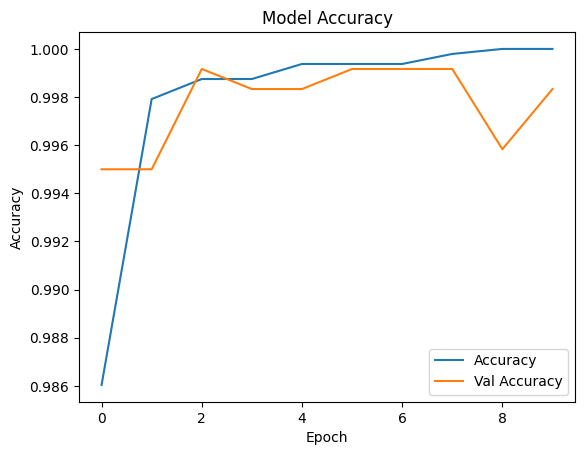

In [ ]:
# 성능 그래프
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### 5. Predict

In [ ]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_generator))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 2)


In [ ]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

array([[0.39607847, 0.37254906, 0.33333337],
       [0.35686278, 0.33333337, 0.2941177 ],
       [0.30196083, 0.27843142, 0.23921573],
       [0.24705887, 0.22352946, 0.18431377],
       [0.22352946, 0.20000005, 0.16078436],
       [0.20784318, 0.18431377, 0.14509809],
       [0.20784318, 0.18431377, 0.14509809],
       [0.20784318, 0.18431377, 0.14509809],
       [0.30980396, 0.28627455, 0.24705887],
       [0.3411765 , 0.3176471 , 0.27843142]], dtype=float32)

In [ ]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.reshape(-1, 224,224,3))
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img)
    i = i + 1

Output hidden; open in https://colab.research.google.com to view.

## 배운 내용 정리
1. imageDataGenerator 와 flow_from_directory 활용하여 쉽게 DataSet을 만들수 있었습니다.
2. Transfer Learning을 사용하는 방법을 배웠으며 이전 CNN 모델과 Transfer Learning 모델과 비교해 보면 엄청난 성능 차이를 보여 주교 있음을 알수 있습니다.
3. 여러분도 이미지 모델 만들때 Transfer Learning을 활용하여 이미지 성능을 높이면 되겠습니다..